# Predicting camera quality using reviews.

*Author: Yusef Ahsini Ouariaghli*

This project is about a creation of a Neural Network using Keras to predict the camera quality of a smartphone with users reviews. The objective is that with only one review from a retailer like Amazon, we can estimate the quality of a phone's camera. 


### Our data.

The data we're going to use in this project has been obtained using web-scrapping techniques. The first of our data-sets has more than 80000 smartphone reviews from the top online retailers worldwide, all of them translated to English. The second contains the specs and the DXO mark camera test result for all the phones in our reviews file. The number of reviews is higher for Samsung and Apple devices because these two manufacturers are the ones with more sales, so the resulting model from using this data will tend to predict them better. 

Since the data was used and integrated for the course <b>Project II, data integration and reparation</b> in my Data Science B.Sc. we will skip the cleaning because it was already done.

### Integration, processing and exploratory analysis.

Our objective in this first part is to obtain a data frame with the review, the final camera score, and some basic smartphone specs related to the camera and hardware. Once we have it, we're going to process the text from the review column lowercasing all the word, removing the punctuation, the stop words and digits. We're also going to center and scale all the numeric variables. 

We read the two files with the reviews and the specs, and we merge them into a unique `DataFrame`.

In [1]:
import pandas as pd

reviews = pd.read_csv("english_reviews.csv", sep=";")
reviews.rename(columns={"device": "Device"}, inplace=True)
specs = pd.read_csv("specs.csv", sep=";")
specs.loc[61,"Apertura_1"] = 1.5 #Galaxy S9, with variable aperture, we transform it to the lowest value
specs["Apertura_1"] = specs["Apertura_1"].apply(lambda x: float(x))
specs = specs[["Device","final_score","Apertura_1", "Resolucion_1","Tama�.o_pixel_1", "Numero_camaras","Puntuacion_CPU","Ram"]]
df = pd.merge(reviews, specs, how="inner", on="Device")

With the final `DataFrame` we plot how many reviews we have to each manufacture. We can see that the predominant brand in our data is Samsung, so the model we build using this information will be more accurate with Samsung reviews. 

<AxesSubplot:title={'center':'Amount of reviews for each manufacturer'}>

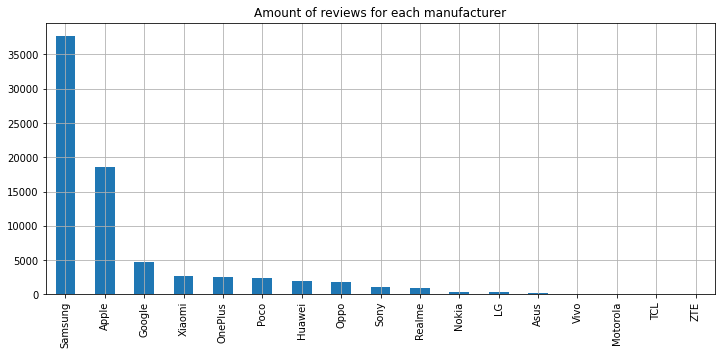

In [2]:
df["manufacturer"].value_counts().plot(kind="bar", title="Amount of reviews for each manufacturer", grid=True, figsize=(12,5))

The next lines of will select only the columns we're going to use in the next part of the creation of the prediction model.

In [3]:
df = df.loc[:,["comentario","final_score","Apertura_1", "Resolucion_1","Tama�.o_pixel_1", "Numero_camaras","Puntuacion_CPU","Ram"]]
df.rename(columns={"comentario":"review", "final_score":"camera_score","Apertura_1":"main_aperture", "Resolucion_1":"camera_res","Tama�.o_pixel_1":"main_pixel_size", "Numero_camaras":"n_cameras","Puntuacion_CPU":"cpu_benckmark","Ram":"ram"}, inplace=True)
df.head()

,review,camera_score,main_aperture,camera_res,main_pixel_size,n_cameras,cpu_benckmark,ram
0,"Incredible screen, cameras, battery, pen.........",131,1.8,108,0.8,4,897556,8
1,Watch out for Samsung. Eye replacement policie...,131,1.8,108,0.8,4,897556,8
2,"Very good, but the software needs optimization...",131,1.8,108,0.8,4,897556,8
3,Impressive\nIt is a renewed mobile with respec...,131,1.8,108,0.8,4,897556,8
4,An aesthetic and functional jewel.\nAfter my N...,131,1.8,108,0.8,4,897556,8


We scale and center the numeric variables making them to have a std of 1 and a mean of 0.

In [4]:
df["camera_score"] = (df["camera_score"]-df["camera_score"].mean())/df["camera_score"].std()
df["main_aperture"] = (df["main_aperture"]-df["main_aperture"].mean())/df["main_aperture"].std()
df["camera_res"] = (df["camera_res"]-df["camera_res"].mean())/df["camera_res"].std()
df["main_pixel_size"] = (df["main_pixel_size"]-df["main_pixel_size"].mean())/df["main_pixel_size"].std()
df["n_cameras"] = (df["n_cameras"]-df["n_cameras"].mean())/df["n_cameras"].std()
df["cpu_benckmark"] = (df["cpu_benckmark"]-df["cpu_benckmark"].mean())/df["cpu_benckmark"].std()
df["ram"] = (df["ram"]-df["ram"].mean())/df["ram"].std()

To understand a bit more what kind of smartphone we have in our data, we will use pandas function `.describe()` to see how it's. And since we centered it, we can compare the distribution of each column. We can see that the camera_score, the variable we want to predict, has a max of 2.03 and a min of -2.9, with 50% of the phones between -0.5 and 0.7. Also, we can appreciate that the median is 0.14, very close to the mean.

In [5]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,camera_score,main_aperture,camera_res,main_pixel_size,n_cameras,cpu_benckmark,ram
count,75526.00000,75526.00000,75526.00000,75089.00000,75526.00000,75526.00000,75526.00000
mean,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
min,-2.90393,-2.27530,-0.80253,-1.34834,-2.88981,-2.54938,-1.58663
25%,-0.50607,-0.56742,-0.80253,-1.10642,-0.33887,-0.59775,-0.57180
50%,0.14790,0.28652,-0.02451,-0.13872,-0.33887,0.09072,0.10475
75%,0.72920,0.28652,0.32129,1.14348,0.93660,0.84296,1.45786
max,2.03712,3.70229,4.29788,1.55475,0.93660,1.71348,1.45786


The last step before start working with the neural network, it's to clean the text. Removing punctuation, stop words and digits. We're also going to convert all the text to lowercase.

In [6]:
from nltk.corpus import stopwords
import string

stop = stopwords.words("english")

df["review"] = df["review"].apply(lambda x: " ".join([word.translate(str.maketrans('', '', string.punctuation)) for word in x.split()]))
df["review"] = df["review"].apply(lambda x: " ".join([word for word in x.split() if word not in (stop)]))
df["review"] = df["review"].apply(lambda x: " ".join([word.lower() for word in x.split()]))
df["review"] = df["review"].apply(lambda x: " ".join([word for word in x.split() if any(i.isdigit() for i in word) == False ]))
df

,review,camera_score,main_aperture,camera_res,main_pixel_size,n_cameras,cpu_benckmark,ram
0,incredible screen cameras battery pen i convin...,1.092509,0.286524,1.272209,-1.106417,0.936599,1.713480,0.104754
1,watch samsung eye replacement policies i samsu...,1.092509,0.286524,1.272209,-1.106417,0.936599,1.713480,0.104754
2,very good software needs optimization it mobil...,1.092509,0.286524,1.272209,-1.106417,0.936599,1.713480,0.104754
3,impressive it renewed mobile respect previous ...,1.092509,0.286524,1.272209,-1.106417,0.936599,1.713480,0.104754
4,an aesthetic functional jewel after note edge ...,1.092509,0.286524,1.272209,-1.106417,0.936599,1.713480,0.104754
...,...,...,...,...,...,...,...,...
75521,loud bright good enough real name the phones g...,-2.903929,-0.567417,4.297876,-0.864493,-0.338871,-2.316779,-1.248356
75522,marcys review samsung galaxy ds cm gb gb dual ...,-2.903929,-0.567417,4.297876,-0.864493,-0.338871,-2.316779,-1.248356
75523,first yes the samsung galaxy cheap first glanc...,-2.903929,-0.567417,4.297876,-0.864493,-0.338871,-2.316779,-1.248356
75524,reviews confirmed there desire change apple sa...,-2.903929,-0.567417,4.297876,-0.864493,-0.338871,-2.316779,-1.248356


In [7]:
df["review"] = [line.split() for line in df["review"]] #split all the text in individual words

### Neural network training and validation.

With all the data clean, we're going to start building our model. Since we are trying to predict using text as input, it has to be transformed  to a numeric value using Keras function `Tokenizer`, that will create a dictionary with the words in our training set. The result will be a list where each position corresponds to the position of a word in a dictionary, if its value is a 0 the word isn't in the text and if it's 1 it is in. We will limit the word in the dictionary to 14000 words due to limited computational resources.

In [8]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2) #80% train, 20% test

t = Tokenizer()
t.fit_on_texts(train["review"])
t.num_words = 14000

#binary works better than count in most cases because it doesn't make the prediction dependent on the review size

train["review"] = list(t.texts_to_matrix(train["review"], mode='binary'))
test["review"] = list(t.texts_to_matrix(test["review"], mode='binary'))

train.to_csv("train.csv", sep=";")
test.to_csv("test.csv", sep=";")

# If you downlad the code from GitHub just uncomment the next lines.
#test = pd.read_csv("test.csv", sep=";")
#train = pd.read_csv("train.csv", sep=";")


trainX, trainY = np.stack(train["review"].values),  train["camera_score"].values
testX, testY = np.stack(test["review"].values), test["camera_score"].values

lst = [train, test] # we delete them to save memory
del train, test 
del lst

<ipython-input-8-e6d13601808b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["review"] = list(t.texts_to_matrix(train["review"], mode='binary'))
<ipython-input-8-e6d13601808b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["review"] = list(t.texts_to_matrix(test["review"], mode='binary'))


Now we create our neural network with an input layer size of 14000, the size of the dictionary. We only use one hidden layer with 15 nodes (this is the configuration that suits better to our data after trying more than 10 different options) and the ReLu activation function. The output is the DXO mark expected values for the review (centered and scaled). 

In [9]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(15, activation="relu", input_shape=(14000,)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

To train the model, we will use up to 25 epochs if it's necessary, but use the callback parameter to stop optimizing when the model starts to overfit the training data. We use the mean squared error to measure how precise is the prediction.

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='camera_quality_from_reviews.h5', monitor='val_loss', save_best_only=True)]

model.fit(trainX, trainY, epochs=25 ,validation_data=(testX, testY), batch_size=128, verbose=1,callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 13s 21ms/step - loss: 0.6939 - val_loss: 0.6248
Epoch 2/25
473/473 [==============================] - 4s 9ms/step - loss: 0.5527 - val_loss: 0.6034
Epoch 3/25
473/473 [==============================] - 4s 9ms/step - loss: 0.4907 - val_loss: 0.6026
Epoch 4/25
473/473 [==============================] - 4s 8ms/step - loss: 0.4470 - val_loss: 0.6124
Epoch 5/25
473/473 [==============================] - 4s 8ms/step - loss: 0.4116 - val_loss: 0.6179


In [11]:
#You can load the model directly with the next lines 
#from keras.models import load_model
#model = load_model("camera_quality_from_reviews.h5")

predict = model.predict(testX)

473/473 [==============================] - 8s 3ms/step


### Conclusion

After creating our model and predicting the test data and comparing it to the real value, we can observe that most of the review predictions are not far from the real value. The average deviation from the real value is 0.6, not bad when the values are between -3 and 2. 

With more reviews, we would get a more accurate model, specially with the worst cameras. They are predicted higher than the actual value due to the low number of reviews of this kind of phones, but even in the worst prediction for a bad camera it will be predicted as average. 

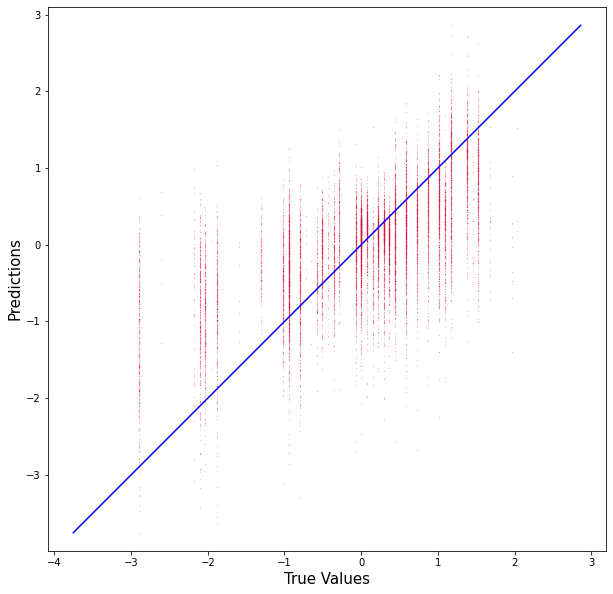

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(testY, predict, c='crimson',s=0.01)

p1 = max(max(predict), max(testY))
p2 = min(min(predict), min(testY))
plt.plot([p1, p2], [p1, p2], 'b-', markersize=0.001)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Try it yourself!

Find a review from any smartphone online and try the model (the longer it's, the better). Be careful, since the next lines doesn't delete punctuation and digits.

In [13]:
text_review = input("Introduce the review:")
model.predict(t.texts_to_matrix([text_review.lower().split()], mode='count'))

Introduce the review:samsung 
1/1 [==============================] - 0s 47ms/step


array([[-0.7081269]], dtype=float32)